# Vision Introduction

This page demonstrates how to train various SOTA computer vision self-supervised models just in few lines!

In [1]:
from fastai.vision.all import *

First, you need to create you Dataloaders. You should keep it as simple as just reading and resizing without any data augmentations. Data augmentations will be passed separately as we will see in the next sections. 

In [2]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.9)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms, device='cpu')
    return dls

In [3]:
bs,resize,size = 64,160,128
dls = get_dls(resize, bs)

If you are training self-supervised models it's most likely that your data is unlabeled. In this case you can create your dataloaders with a dummy target function as following:

In [4]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    def dummy_label(o): return 0
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=0.9)], [dummy_label]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms, device='cpu')
    return dls

In [5]:
bs,resize,size = 64,160,128
dls = get_dls(resize, bs)

### Common Imports

In [6]:
from self_supervised.layers import *

## SimCLR

In [7]:
from self_supervised.vision.simclr import *

In [8]:
encoder = create_encoder("xresnet34", n_in=3, pretrained=False)
model = create_simclr_model(encoder, hidden_size=2048, projection_size=128)
aug_pipelines = get_simclr_aug_pipelines(size=size, rotate=True, jitter=True, bw=True, blur=True, blur_s=(4,16), blur_p=0.25, cuda=False)
learn = Learner(dls, model,loss_func=noop,cbs=[SimCLR(aug_pipelines, temp=0.07, print_augs=True),ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 0.25, 's': (4, 16), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 0.25, 's': (4, 16), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}


In [9]:
# for inspecting data augmentations
b = dls.one_batch()
learn._split(b)
learn('before_batch')

Always check your data augmentations to see whether they make sense or not before moving forward with training.

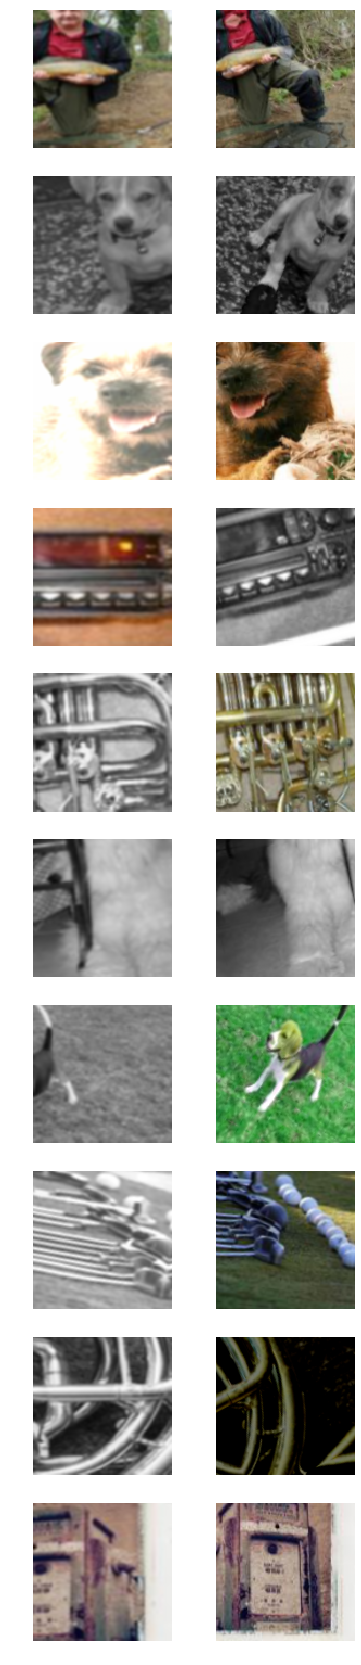

In [10]:
learn.sim_clr.show(n=10);

In [11]:
# learn.fit_flat_cos(100)

### MoCo

In [12]:
from self_supervised.vision.moco import *

In [13]:
encoder = create_encoder("xresnet34", n_in=3, pretrained=False)
model = create_moco_model(encoder, hidden_size=1024, projection_size=128)
aug_pipelines = get_moco_aug_pipelines(size=size, rotate=True, jitter=True, bw=True, blur=False, jitter_p=0.5, cuda=False)
learn = Learner(dls, model,loss_func=noop,cbs=[MOCO(aug_pipelines=aug_pipelines, K=128, print_augs=True),ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}


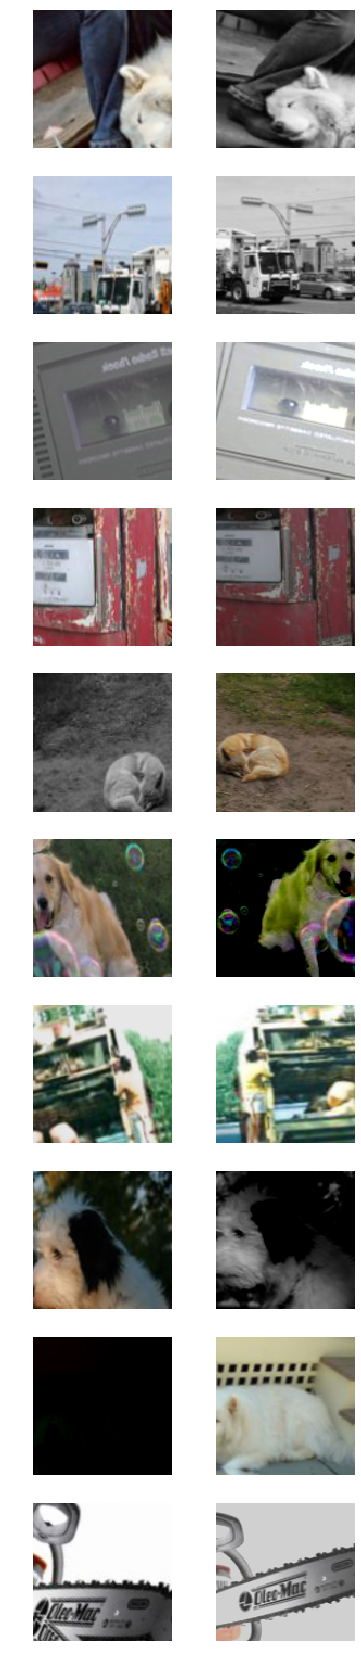

In [14]:
b = dls.one_batch()
learn._split(b)
learn.pred = learn.model(*learn.xb)
axes = learn.moco.show(n=10)

## BYOL

In [15]:
from self_supervised.vision.byol import *

In [16]:
encoder = create_encoder("xresnet34", n_in=3, pretrained=False)
model =  create_byol_model(encoder, hidden_size=4096, projection_size=256)
aug_pipelines = get_byol_aug_pipelines(size=size, rotate=True, jitter=True, bw=True, blur=False, jitter_p=0.5, cuda=False)
learn = Learner(dls, model,loss_func=noop,cbs=[BYOL(aug_pipelines=aug_pipelines,print_augs=True),ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}


In [17]:
# for inspecting data augmentations
b = dls.one_batch()
learn._split(b)
learn('before_fit')
learn('before_batch')

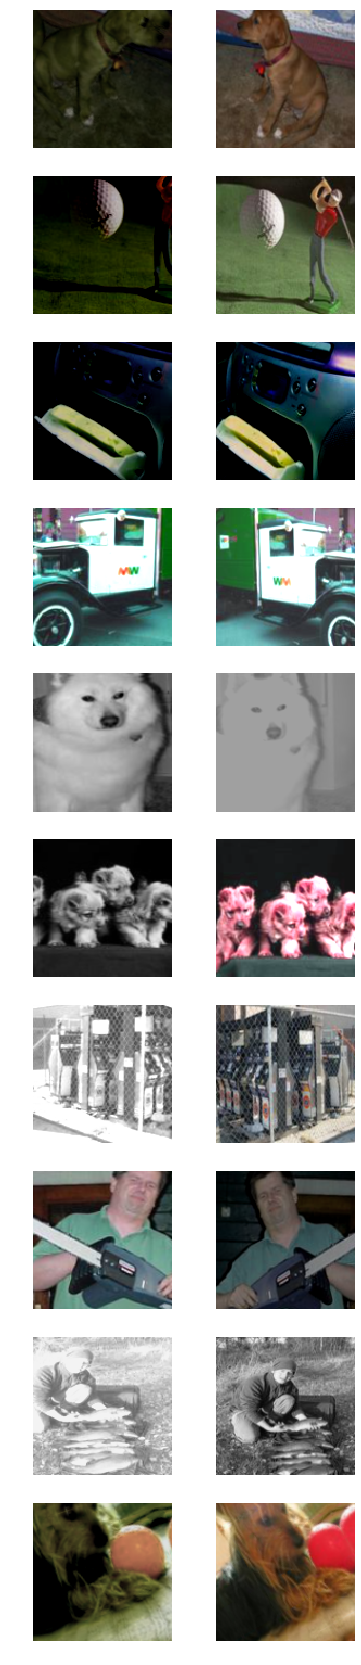

In [18]:
learn.byol.show(n=10);

## SwAV

In [19]:
from self_supervised.vision.swav import *

In [20]:
encoder = create_encoder("xresnet34", n_in=3, pretrained=False)
model = create_swav_model(encoder, hidden_size=2048, projection_size=128)
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[128,96], 
                                       min_scales=[0.25,0.05],
                                       max_scales=[1.0,0.3],
                                       rotate=True, jitter=True, bw=True, blur=False, jitter_p=0.5, cuda=False)
learn = Learner(dls, model, loss_func=noop, cbs=[SWAV(aug_pipelines=aug_pipelines, crop_assgn_ids=[0,1], K=bs*2**6, queue_start_pct=0.5), ShortEpochCallback(0.001)])

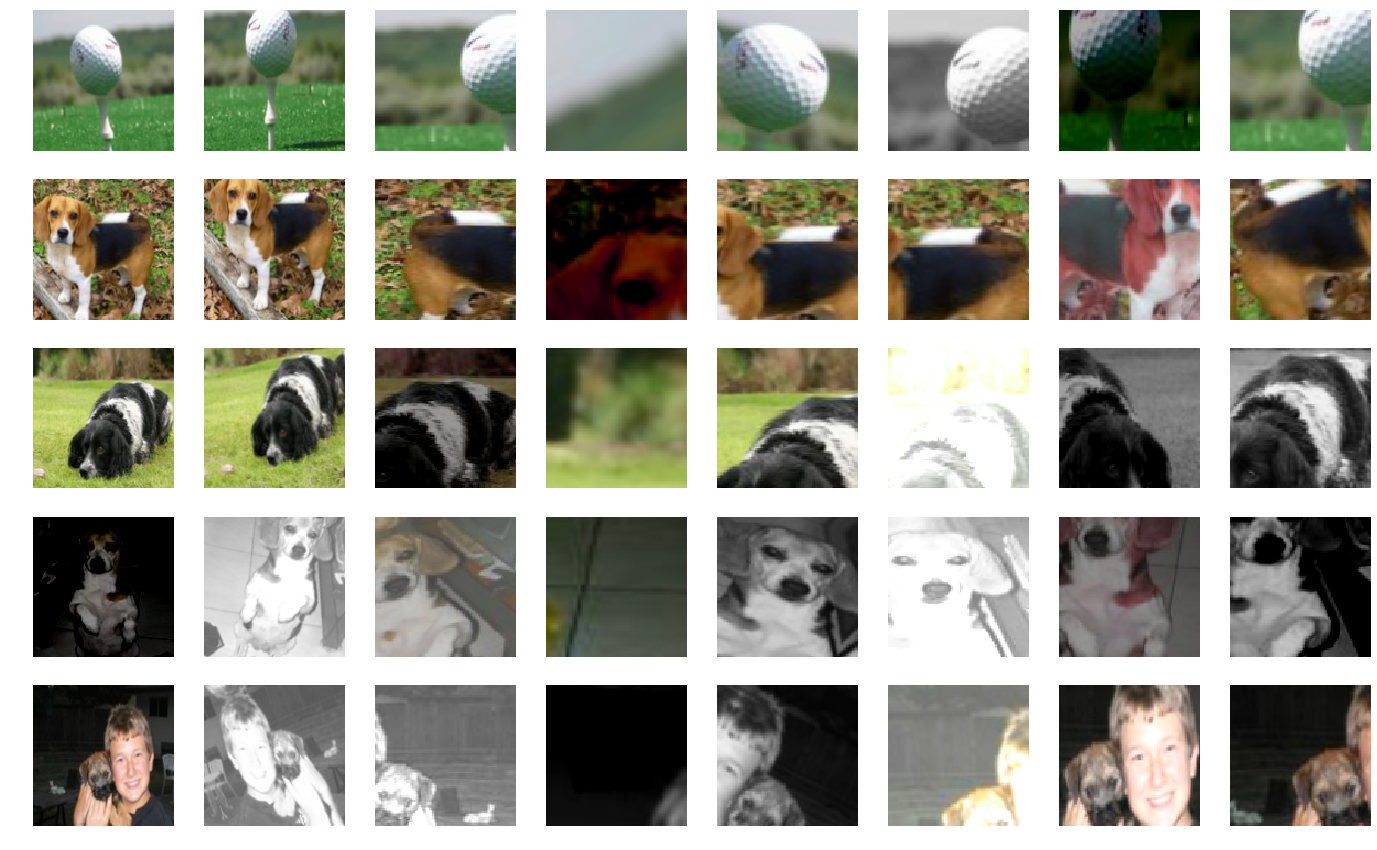

In [23]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show(n=5);